In [1]:
#!git clone "https://github.com/jyanivaddi/ERA_V1.git"
#!git pull

Cloning into 'ERA_V1'...
remote: Enumerating objects: 326, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 326 (delta 46), reused 59 (delta 23), pack-reused 237
Receiving objects: 100% (326/326), 5.14 MiB | 7.79 MiB/s, done.
Resolving deltas: 100% (164/164), done.
fatal: not a git repository (or any of the parent directories): .git


Add all the imports

In [2]:
from __future__ import print_function
import sys
sys.path.append("ERA_V1/session_8")
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from s8_utils import load_cifar10_data, preview_batch_images, plot_statistics
from s8_model import Model_Net, model_summary, model_train, model_test

Allocate GPU

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
cifar_10_model = Model_Net().to(device)
model_summary(cifar_10_model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
       BatchNorm2d-6           [-1, 32, 32, 32]              64
              ReLU-7           [-1, 32, 32, 32]               0
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]           2,048
      BatchNorm2d-10           [-1, 64, 32, 32]             128
             ReLU-11           [-1, 64, 32, 32]               0
          Dropout-12           [-1, 64, 32, 32]               0
        MaxPool2d-13           [-1, 64, 16, 16]               0
           Conv2d-14           [-1, 64,

/content/ERA_V1/session_8/s8_model.py:145: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Define Transforms

In [4]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.491, 0.482, 0.447), (0.247, 0.244, 0.262))
])
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.491, 0.482, 0.447), (0.247, 0.244, 0.262))
])

Download Data

In [5]:
train_data, test_data, class_names = load_cifar10_data(train_transforms, test_transforms)

100%|██████████| 170498071/170498071 [00:13<00:00, 12238877.01it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


Define train and test loaders

In [6]:
torch.manual_seed(1)
batch_size = 128
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle = True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = True, **kwargs)

Calculate Mean and Std of dataset

In [7]:
from tqdm import tqdm
import numpy as np
mean_r = 0
mean_g = 0
mean_b = 0

std_r = 0
std_g = 0
std_b = 0
loader_for_stats = test_loader
for img,_ in tqdm(loader_for_stats):
    img = np.asarray(img)
    # calculate Mean of Normalized dataset
    mean_r += np.mean(img[:,0,:,:])
    mean_g += np.mean(img[:,1,:,:])
    mean_b += np.mean(img[:,2,:,:])
    # calculate std of Normalized dataset
    std_r += np.var(img[:,0,:,:])
    std_g += np.var(img[:,1,:,:])
    std_b += np.var(img[:,2,:,:])
mean_r = mean_r / len(loader_for_stats)
mean_g = mean_g / len(loader_for_stats)
mean_b = mean_b / len(loader_for_stats)
std_r = np.sqrt(((1./(len(loader_for_stats)-1))*std_r))
std_g = np.sqrt(((1./(len(loader_for_stats)-1))*std_g))
std_b = np.sqrt(((1./(len(loader_for_stats)-1))*std_b))
print(f"dataset mean: {mean_r:0.3f}, {mean_g:0.3f}, {mean_b:0.3f}")
print(f"dataset std: {std_r:0.3f}, {std_g:0.3f}, {std_b:0.3f}")


100%|██████████| 79/79 [00:03<00:00, 22.07it/s]

dataset mean: 0.013, 0.014, 0.015
dataset std: 1.005, 1.002, 1.004


Show sample Images

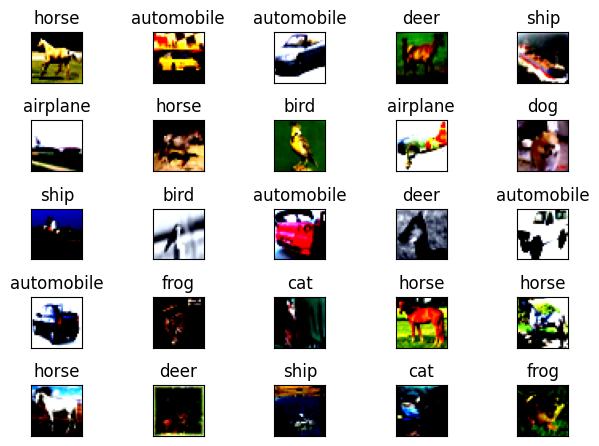

In [8]:
import matplotlib.pyplot as plt
import numpy as np
def preview_images(train_loader, num_rows = 5, num_cols = 5):
    batch_data, batch_label = next(iter(train_loader))
    num_images_to_preview = num_rows*num_cols
    fig = plt.figure()
    for cnt in range(num_images_to_preview):
        plt.subplot(num_rows,num_cols,cnt+1)
        plt.tight_layout()
        this_img = np.asarray(batch_data[cnt])
        plt.imshow(this_img.transpose((1,2,0)))
        plt.title(class_names[str(batch_label[cnt].item())])
        plt.xticks([])
        plt.yticks([])
    plt.show()

preview_images(train_loader,num_rows = 5, num_cols = 5)

In [9]:
model = Model_Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1, verbose=True)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True)
train_losses = []
test_losses = []
train_acc = []
test_acc = []
for epoch in range(1,20):
    print(f"epoch: {epoch}")
    this_train_loss = model_train(model, device, train_loader, optimizer, train_acc, train_losses)
    this_loss = model_test(model, device, test_loader, test_acc, test_losses)
    #scheduler.step()
    #print(optimizer.)


epoch: 1


loss=1.0471434593200684 batch_id=390 Accuracy = 47.97: 100%|██████████| 391/391 [00:18<00:00, 20.95it/s]



Test set: Average loss: 1.2580, Accuracy: 5233/10000 (52.33%)

epoch: 2


loss=0.8011530637741089 batch_id=390 Accuracy = 65.61: 100%|██████████| 391/391 [00:18<00:00, 20.59it/s]



Test set: Average loss: 1.1687, Accuracy: 5869/10000 (58.69%)

epoch: 3


loss=0.7171593308448792 batch_id=390 Accuracy = 71.97: 100%|██████████| 391/391 [00:19<00:00, 20.38it/s]



Test set: Average loss: 1.0783, Accuracy: 6300/10000 (63.00%)

epoch: 4


loss=0.47064048051834106 batch_id=390 Accuracy = 76.04: 100%|██████████| 391/391 [00:18<00:00, 21.09it/s]



Test set: Average loss: 0.9847, Accuracy: 6412/10000 (64.12%)

epoch: 5


loss=0.4669513702392578 batch_id=390 Accuracy = 78.90: 100%|██████████| 391/391 [00:18<00:00, 21.55it/s]



Test set: Average loss: 0.7509, Accuracy: 7361/10000 (73.61%)

epoch: 6


loss=0.5808656215667725 batch_id=390 Accuracy = 80.95: 100%|██████████| 391/391 [00:18<00:00, 20.68it/s]



Test set: Average loss: 0.8178, Accuracy: 7180/10000 (71.80%)

epoch: 7


loss=0.40139347314834595 batch_id=390 Accuracy = 82.17: 100%|██████████| 391/391 [00:19<00:00, 20.43it/s]



Test set: Average loss: 0.6735, Accuracy: 7644/10000 (76.44%)

epoch: 8


loss=0.4545847475528717 batch_id=390 Accuracy = 83.75: 100%|██████████| 391/391 [00:18<00:00, 21.54it/s]



Test set: Average loss: 0.6541, Accuracy: 7756/10000 (77.56%)

epoch: 9


loss=0.36644163727760315 batch_id=390 Accuracy = 84.56: 100%|██████████| 391/391 [00:18<00:00, 21.14it/s]



Test set: Average loss: 0.6344, Accuracy: 7831/10000 (78.31%)

epoch: 10


loss=0.31083542108535767 batch_id=390 Accuracy = 85.56: 100%|██████████| 391/391 [00:19<00:00, 20.24it/s]



Test set: Average loss: 0.6420, Accuracy: 7845/10000 (78.45%)

epoch: 11


loss=0.4650176465511322 batch_id=390 Accuracy = 86.22: 100%|██████████| 391/391 [00:17<00:00, 21.77it/s]



Test set: Average loss: 0.6713, Accuracy: 7675/10000 (76.75%)

epoch: 12


loss=0.4282473027706146 batch_id=390 Accuracy = 86.64: 100%|██████████| 391/391 [00:19<00:00, 20.57it/s]



Test set: Average loss: 0.6048, Accuracy: 7914/10000 (79.14%)

epoch: 13


loss=0.44798994064331055 batch_id=390 Accuracy = 87.49: 100%|██████████| 391/391 [00:19<00:00, 20.52it/s]



Test set: Average loss: 0.5229, Accuracy: 8169/10000 (81.69%)

epoch: 14


loss=0.40104079246520996 batch_id=390 Accuracy = 88.22: 100%|██████████| 391/391 [00:19<00:00, 20.51it/s]



Test set: Average loss: 0.5710, Accuracy: 8042/10000 (80.42%)

epoch: 15


loss=0.3753349483013153 batch_id=390 Accuracy = 88.74: 100%|██████████| 391/391 [00:17<00:00, 21.73it/s]



Test set: Average loss: 0.5644, Accuracy: 8066/10000 (80.66%)

epoch: 16


loss=0.27593979239463806 batch_id=390 Accuracy = 89.16: 100%|██████████| 391/391 [00:18<00:00, 21.21it/s]



Test set: Average loss: 0.5869, Accuracy: 7969/10000 (79.69%)

epoch: 17


loss=0.23643775284290314 batch_id=390 Accuracy = 89.77: 100%|██████████| 391/391 [00:19<00:00, 20.54it/s]



Test set: Average loss: 0.4969, Accuracy: 8244/10000 (82.44%)

epoch: 18


loss=0.32690948247909546 batch_id=390 Accuracy = 90.18: 100%|██████████| 391/391 [00:18<00:00, 21.46it/s]



Test set: Average loss: 0.5187, Accuracy: 8262/10000 (82.62%)

epoch: 19


loss=0.4803192615509033 batch_id=390 Accuracy = 90.61: 100%|██████████| 391/391 [00:18<00:00, 21.62it/s]



Test set: Average loss: 0.5989, Accuracy: 7988/10000 (79.88%)



Plot Statistics

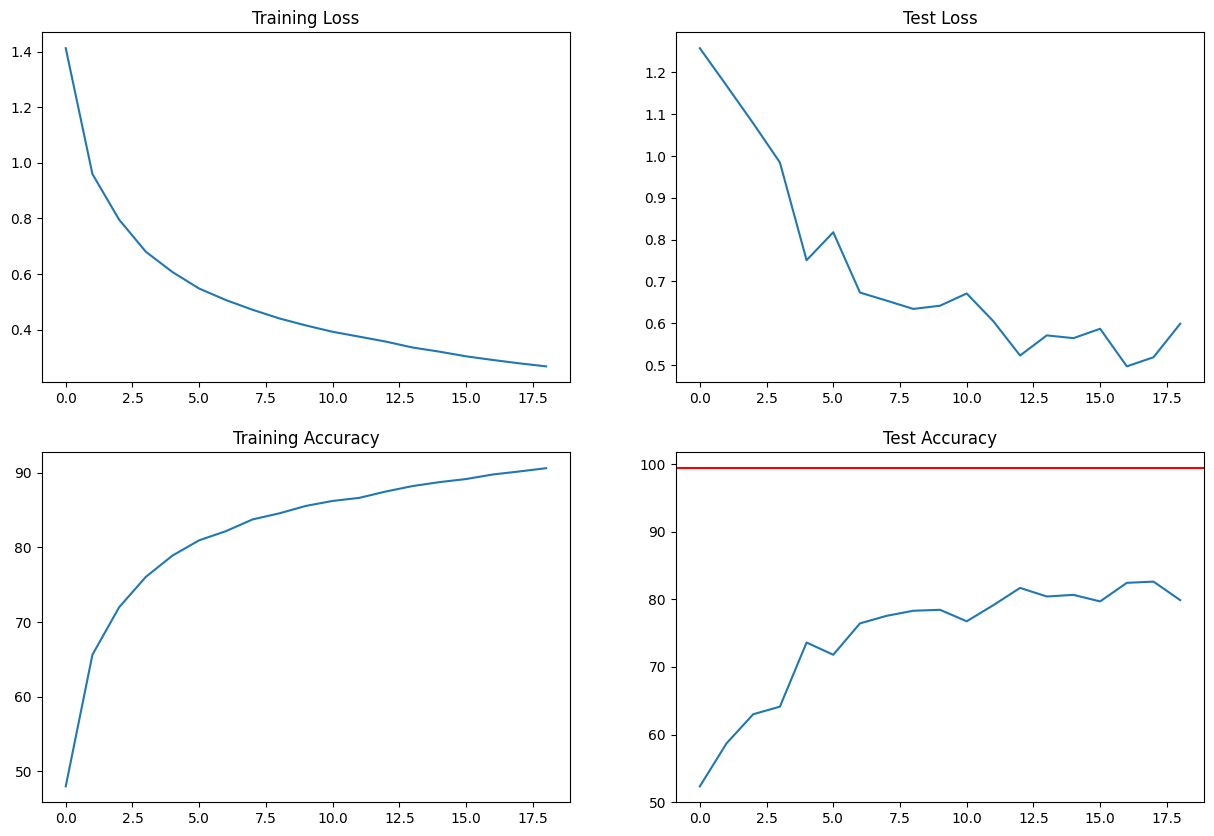

In [10]:
plot_statistics(train_losses, train_acc, test_losses, test_acc)